In [31]:
import pandas as pd
import numpy as np

In [2]:
s = 'SESSIONx'

In [5]:
ev = pd.read_csv(r".\data\SESSIONx_EVENTS.csv")

In [7]:
ev.rename(columns={'Pico_gTime_s': 'time'}, inplace=True)

In [42]:
array_start = 0
array_end = round(ev['time'].values.max())
fs = 1000

master_times_array = np.arange(array_start, array_end, 1/fs)

In [ ]:
lick_times = ev.loc[ev.Lick_Detected == 'Lick']['time'].values
valve_opens = ev.loc[ev.Valve_timing == 'Open']['time'].values
valve_closes = ev.loc[ev.Valve_timing == 'Close']['time'].values

In [ ]:
motor_indices = ev['Motor_location'].dropna().index.values
motor_events = ev.iloc[motor_indices]['Motor_location'].values
motor_event_times = ev.iloc[motor_indices]['time'].values

motor_values_array = np.zeros_like(master_times_array)
evt_times = np.asarray(motor_event_times, dtype=float)
evt_names = np.asarray(motor_events).astype(str)

# Ensure events are processed in chronological order
order = np.argsort(evt_times)
evt_times = evt_times[order]
evt_names = np.char.lower(evt_names[order])

num_events = len(evt_names)
for i in range(num_events):
    name = evt_names[i].strip()
    t0 = float(evt_times[i])
    # Use end of array for the final interval
    t1 = float(evt_times[i + 1]) if i + 1 < num_events else (master_times_array[-1] + 1.0 / fs)

    idx0 = int(np.searchsorted(master_times_array, t0, side='left'))
    idx1 = int(np.searchsorted(master_times_array, t1, side='left'))
    if idx1 <= idx0:
        continue

    seg_times = master_times_array[idx0:idx1]
    if name == 'forward':
        denom = max(t1 - t0, 1e-12)
        motor_values_array[idx0:idx1] = np.clip((seg_times - t0) / denom, 0.0, 1.0)
    elif name == 'backward':
        denom = max(t1 - t0, 1e-12)
        motor_values_array[idx0:idx1] = 1.0 - np.clip((seg_times - t0) / denom, 0.0, 1.0)
    elif name == 'presenting':
        motor_values_array[idx0:idx1] = 1.0
    elif name == 'idle':
        motor_values_array[idx0:idx1] = 0.0
    # unknown labels are left as-in (zeros)

In [25]:
state_indices = ev['State'].dropna().index.values
state_events = ev.iloc[state_indices]['State'].values
state_event_times = ev.iloc[state_indices]['time'].values

In [46]:
start_s = []
end_s = []
labels = []
for i,state in enumerate(state_events):
    start_s.append(state_event_times[i])
    labels.append(state)
    if i < len(state_events) - 1:
        end_s.append(state_event_times[i+1])
    else:
        end_s.append(master_times_array[-1])

In [48]:
states_df = pd.DataFrame({'start_s': start_s, 'end_s': end_s, 'label': labels})

In [52]:
open_indices = np.searchsorted(master_times_array, valve_opens)
close_indices = np.searchsorted(master_times_array, valve_closes)

In [53]:
valve_values = np.zeros_like(master_times_array)
for o, c in zip(open_indices, close_indices):
    valve_values[o:c] = 1.0

In [60]:
lick_times
lick_ends = lick_times + 0.005

In [61]:
lick_values = np.zeros_like(master_times_array)
lick_indices = np.searchsorted(master_times_array, lick_times)
lick_ends_indices = np.searchsorted(master_times_array, lick_ends)
for lick, lick_end in zip(lick_indices, lick_ends_indices):
    lick_values[lick:lick_end] = 1.0

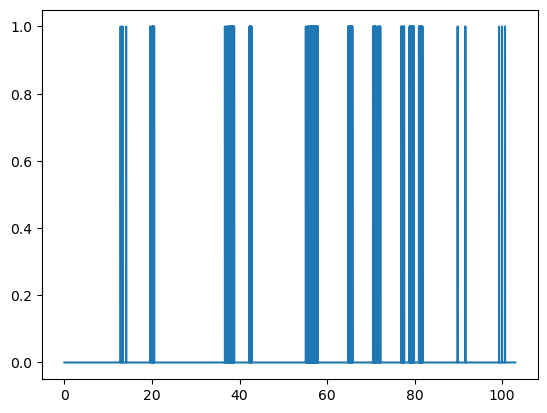

In [62]:
plt.plot(master_times_array, lick_values)

In [64]:
np.save('motor_y.npy', motor_values_array)
np.save('valve_y.npy', valve_values)
np.save('lick_y.npy', lick_values)

np.save('motor_t.npy', master_times_array)
np.save('valve_t.npy', master_times_array)
np.save('lick_t.npy', master_times_array)

In [65]:
states_df.to_csv('states.csv', index=False)

In [67]:
frames = pd.read_csv(r".\data\SESSIONx_FRAMES.csv")

In [71]:
frame_times = frames['Pico_gTime_s'].values

In [72]:
np.save('data\\frame_times.npy', frame_times)